# Adversarial examples with inception model

This notebook shows an example of how to use the provided code to attack an object classification model.

## Setup

In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
batch_shape = [None, 299, 299, 3]

In [3]:
# Code to instantiate an inception model; pre-process images and revert the pre-processing (e.g. for visualization)

from tensorflow.contrib.slim.nets import inception
slim = tf.contrib.slim

class InceptionModel:  
    def __init__(self, end_point='Logits'):
        self.initialized = False
        self.end_point = end_point
        self.num_classes=1001
        
    def __call__(self, x_input):
        if self.initialized:
            reuse = True
        else:
            reuse = False
            self.initialized = True
            
        with slim.arg_scope(inception.inception_v3_arg_scope()):
              _, end_points = inception.inception_v3(
                  x_input, num_classes=self.num_classes, is_training=False, reuse=reuse)
        
        return end_points[self.end_point]
    
def preprocess_image(img):
    return img / 127.5 - 1

def revert_processed_image(img):
    return ((img + 1) * 127.5 ).astype(np.uint8)

In [4]:
# Instantiate the model

tf.reset_default_graph()
x_input = tf.placeholder(tf.float32, shape=batch_shape)
y_input = tf.placeholder(tf.int32, shape=(batch_shape[0]))

model = InceptionModel()
logits = model(x_input)
probs = tf.nn.softmax(logits)
prediction = tf.argmax(logits, axis=1)

# Download the weights (if not yet done)
model_path = 'inception_v3.ckpt'

In [ ]:

if not os.path.exists(model_path):
    import urllib.request
    import tarfile 
    compressed_path = 'inception_v3_2016_08_28.tar.gz'
    
    print('Downloading model')
    
    urllib.request.urlretrieve('http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz', compressed_path)
    
    with tarfile.open(compressed_path, 'r') as compressed_model:
        compressed_model.extractall()
    os.unlink(compressed_path)
    print('Done')

In [5]:
# Load the pre-trained weights

saver = tf.train.Saver(slim.get_model_variables())
sess = tf.InteractiveSession()
saver.restore(sess, model_path)

INFO:tensorflow:Restoring parameters from inception_v3.ckpt


In [6]:
# Load some sample images

from scipy.misc import imread, imsave

img_names = ['images/panda.png', 'images/flag.png']
labels = np.array([389, 558])

imgs = [preprocess_image(imread(f)) for f in img_names]
imgs = np.stack(imgs)
pred, original_probabilities = sess.run([prediction, probs], feed_dict={x_input: imgs})

assert np.all(labels == pred)

with open('imagenet_labels.txt') as f:
    class_names = [line.strip() for line in f.readlines()]
class_names = np.array(class_names)

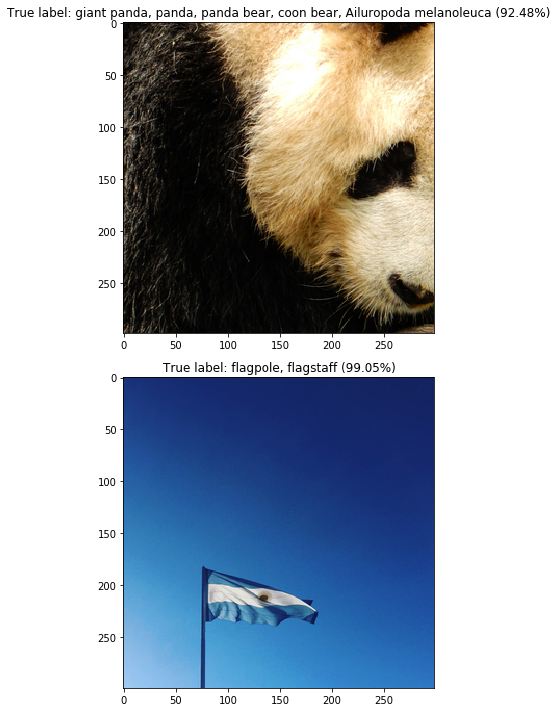

In [7]:
# Let's take a look on the original images

f, ax = plt.subplots(2, 1, figsize=(10,10))
for i, img in enumerate(imgs):
    ax[i].imshow(revert_processed_image(img))
    true_class = labels[i]
    ax[i].set_title('True label: %s (%.2f%%)' % (class_names[true_class], original_probabilities[i, true_class] * 100))
f.tight_layout()

## Calculating the loss:

$J = - \log{P(Y=y_\text{true} | X)}$

In [8]:
#Calculating the loss:

loss = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=y_input)

In [9]:
l, p = sess.run([loss, probs], feed_dict={x_input: imgs, y_input:labels})

print('Loss: %.4f' % l)
print('Probability of correct class: %.4f, %.4f' % (p[0][labels[0]], p[1][labels[1]]))

Loss: 0.0439
Probability of correct class: 0.9248, 0.9905


## Calculating the gradient $\nabla_X{J}$

In [10]:
grad = tf.gradients(loss, x_input)[0]

In [11]:
image_gradient = sess.run(grad, feed_dict={x_input: imgs, y_input: labels})
image_gradient.shape

(2, 299, 299, 3)

## Starting to modify the image: $\tilde{X} = X + \alpha \nabla_X{J}$

In [12]:
lr = 0.5
new_img = imgs + lr * image_gradient

new_img = np.clip(new_img, -1, 1) # Note that we are not constraining on \delta yet

In [13]:
l, p = sess.run([loss, probs], feed_dict={x_input: new_img, y_input: labels})

print('Loss: %.4f' % l)
print('Probability of correct class: %.4f, %.4f' % (p[0][labels[0]], p[1][labels[1]]))

Loss: 0.1276
Probability of correct class: 0.7902, 0.9804


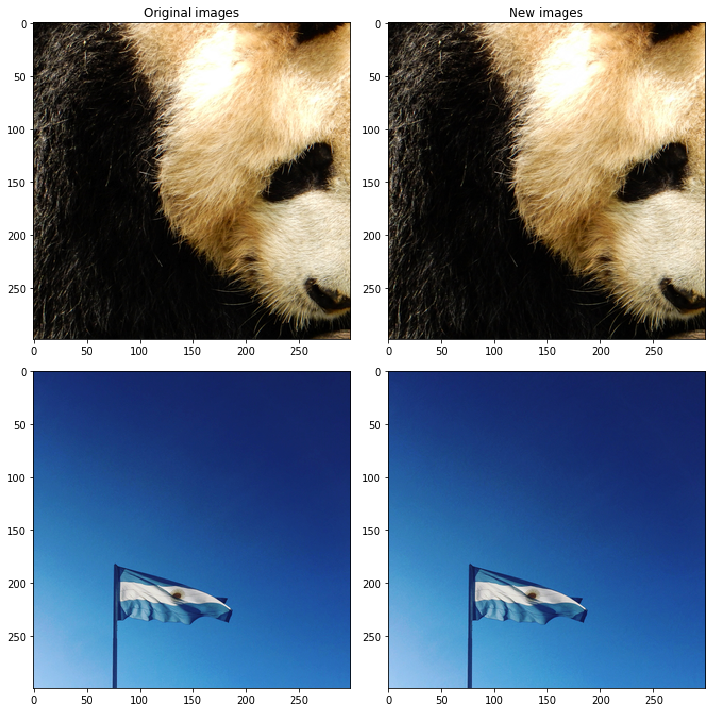

In [14]:
f, ax = plt.subplots(2, 2, figsize=(10,10))
for i, (img, adv_img) in enumerate(zip(imgs, new_img)):
    true_class = labels[i]
    ax[i, 0].imshow(revert_processed_image(img))
    ax[i, 1].imshow(revert_processed_image(adv_img))
ax[0,0].set_title('Original images')
ax[0,1].set_title('New images')
f.tight_layout()

## Fast gradient sign attack:

$\tilde{X} = X + \epsilon \text{sign}(\nabla{J(x, y)})$

In [15]:
epsilon = 4. / 255 * 2 # Change each pixel by a value of 4 (on the 0-255 range)
fgsm_attack = imgs + epsilon * np.sign(image_gradient)
fgsm_attack = np.clip(fgsm_attack, -1, 1)

l, p = sess.run([loss, probs], feed_dict={x_input: fgsm_attack, y_input: labels})

print('Loss: %.4f' % l)
print('Probability of correct class: %.4f, %.4f' % (p[0][labels[0]], p[1][labels[1]]))

Loss: 2.8053
Probability of correct class: 0.0060, 0.6144


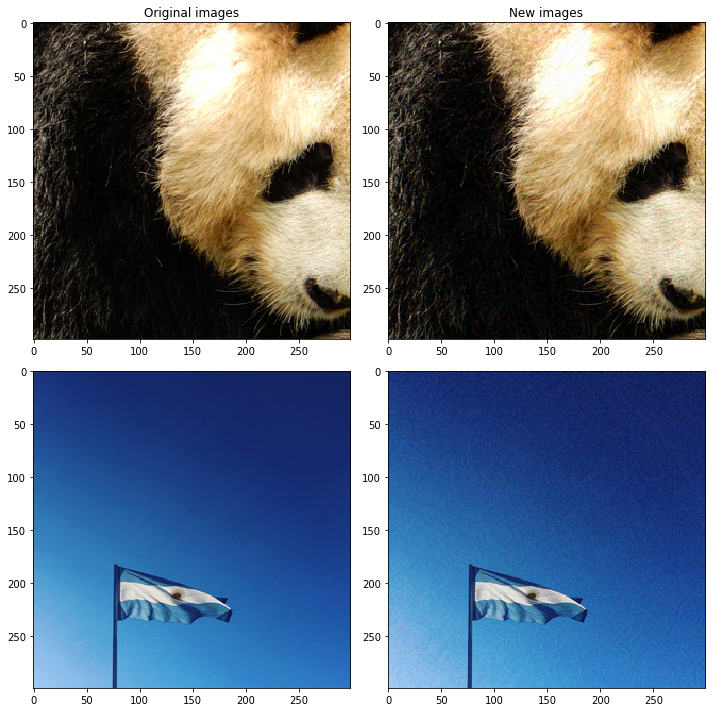

In [16]:
# Let's take a look on the original images


f, ax = plt.subplots(2, 2, figsize=(10,10))
for i, (img, adv_img) in enumerate(zip(imgs, fgsm_attack)):
    true_class = labels[i]
    ax[i, 0].imshow(revert_processed_image(img))
    ax[i, 1].imshow(revert_processed_image(adv_img))
ax[0,0].set_title('Original images')
ax[0,1].set_title('New images')
f.tight_layout()

## Runing the attacks

In [17]:
import adversarial_attacks.pgd_attack # Projected SGD attack
import adversarial_attacks.step_pgd_attack # Step FGMS + projected SGD

In [18]:
# Define some parameters for the attacks:

max_epsilon = 8  # Max epsilon on the original range (0 to 255)
max_iter = 30 # Maximun number of iterations
eps = 2.0 * max_epsilon / 255.0 # Max epsilon on the range of the processed images (-1 to 1)

In [19]:
# First example: Generating non-targeted attacks using the PGD attack
pgd_attacker = adversarial_attacks.pgd_attack.PGD_attack(model, 
                                     batch_shape, 
                                     max_epsilon=eps, 
                                     max_iter=max_iter, 
                                     targeted=False,
                                     initial_lr=1,
                                     lr_decay=0.99)

In [12]:
attack_img = pgd_attacker.generate(sess, imgs, pred, verbose=True)

Iter 0, loss: 10.92
Iter 1, loss: 5.98
Iter 2, loss: 1.15
Iter 3, loss: -0.76
Iter 4, loss: -1.75
Iter 5, loss: -2.66
Iter 6, loss: -3.23
Iter 7, loss: -3.27
Iter 8, loss: -4.75
Iter 9, loss: -3.90
Iter 10, loss: -4.43
Iter 11, loss: -4.34
Iter 12, loss: -4.70
Iter 13, loss: -5.17
Iter 14, loss: -5.45
Iter 15, loss: -5.94
Iter 16, loss: -6.33
Iter 17, loss: -6.60
Iter 18, loss: -5.85
Iter 19, loss: -6.41
Iter 20, loss: -7.10
Iter 21, loss: -7.70
Iter 22, loss: -8.22
Iter 23, loss: -7.30
Iter 24, loss: -7.97
Iter 25, loss: -8.13
Iter 26, loss: -9.32
Iter 27, loss: -8.80
Iter 28, loss: -10.16
Iter 29, loss: -9.58


In [13]:
adv_prediction, adv_probabilities = sess.run([prediction, probs], feed_dict={x_input: attack_img, y_input: labels})

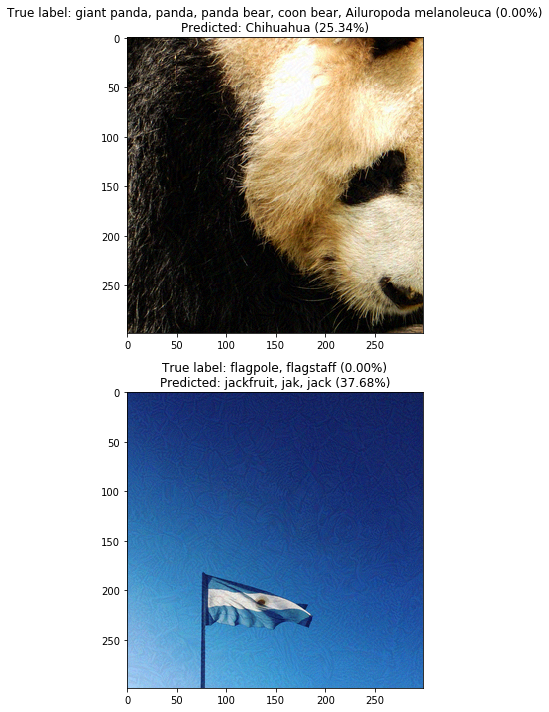

In [14]:
f, ax = plt.subplots(2, 1, figsize=(10,10))
for i, img in enumerate(attack_img):
    ax[i].imshow(revert_processed_image(img))
    true_class = labels[i]
    pred_class = adv_prediction[i]
    title = 'True label: %s (%.2f%%)' % (class_names[true_class], adv_probabilities[i, true_class] * 100)
    title += '\nPredicted: %s (%.2f%%)' % (class_names[pred_class], adv_probabilities[i, pred_class] * 100)
    ax[i].set_title(title)
f.tight_layout()

In [11]:
# 2rd example: targeted attack using step FGSM + PGD 
step_pgd_attacker = adversarial_attacks.step_pgd_attack.step_pgd_attack(model, 
                                     batch_shape, 
                                     max_epsilon=eps, 
                                     max_iter=max_iter, 
                                     targeted=True,
                                     initial_lr=1,
                                     lr_decay=0.99,
                                     alpha=eps/2,
                                     step_iter=5)

attack_img = step_pgd_attacker.generate(sess, imgs, [1, 1], verbose=True)


Iter 0, loss: -0.54
Iter 1, loss: 0.57
Iter 2, loss: 1.57
Iter 3, loss: 2.06
Iter 4, loss: 2.23
Iter 5, loss: 2.44
Iter 6, loss: 6.20
Iter 7, loss: 8.65
Iter 8, loss: 5.83
Iter 9, loss: 8.60
Iter 10, loss: 8.49
Iter 11, loss: 9.27
Iter 12, loss: 9.61
Iter 13, loss: 12.88
Iter 14, loss: 13.22
Iter 15, loss: 14.29
Iter 16, loss: 15.57
Iter 17, loss: 13.25
Iter 18, loss: 14.21
Iter 19, loss: 11.77
Iter 20, loss: 18.25
Iter 21, loss: 16.03
Iter 22, loss: 17.04
Iter 23, loss: 17.69
Iter 24, loss: 19.75
Iter 25, loss: 15.32
Iter 26, loss: 18.79
Iter 27, loss: 14.34
Iter 28, loss: 23.19
Iter 29, loss: 18.96


In [12]:
adv_prediction, adv_probabilities = sess.run([prediction, probs], feed_dict={x_input: attack_img})

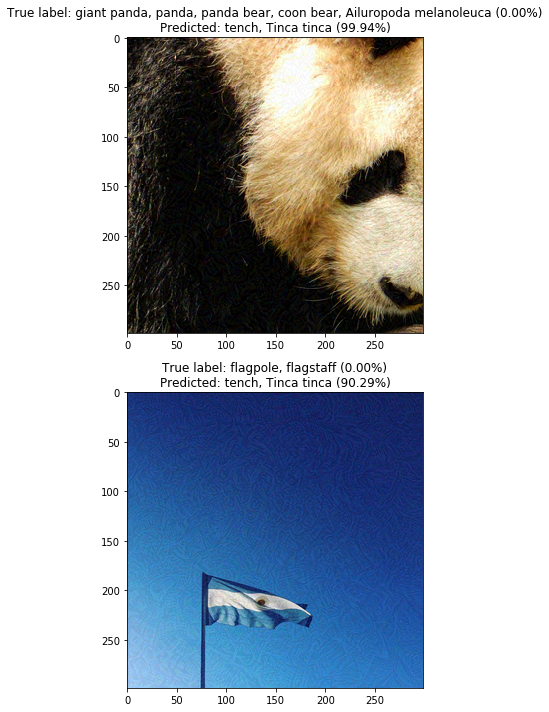

In [13]:
f, ax = plt.subplots(2, 1, figsize=(10,10))
for i, img in enumerate(attack_img):
    ax[i].imshow(revert_processed_image(img))
    true_class = labels[i]
    pred_class = adv_prediction[i]
    title = 'True label: %s (%.2f%%)' % (class_names[true_class], adv_probabilities[i, true_class] * 100)
    title += '\nPredicted: %s (%.2f%%)' % (class_names[pred_class], adv_probabilities[i, pred_class] * 100)
    ax[i].set_title(title)
f.tight_layout()